# Explanations for cloud segmentation

In [1]:
import sys
from cloudsen12_models import cloudsen12
import ee
import matplotlib.pyplot as plt
from georeader import plot
from shapely.geometry import box
from georeader.readers import ee_image

In [2]:
# ee.Authenticate()
ee.Initialize(project='cloud-segmentation-tkwiecinski')

In [3]:
collection_name = "COPERNICUS/S2_HARMONIZED"
tile = "S2A_MSIL1C_20240417T064631_N0510_R020_T40RCN_20240417T091941"
img_col = ee.ImageCollection(collection_name)
image = img_col.filter(ee.Filter.eq("PRODUCT_ID", tile)).first()
info_img = image.getInfo()
info_img

{'type': 'Image',
 'bands': [{'id': 'B1',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [1830, 1830],
   'crs': 'EPSG:32640',
   'crs_transform': [60, 0, 300000, 0, -60, 2800020]},
  {'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32640',
   'crs_transform': [10, 0, 300000, 0, -10, 2800020]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32640',
   'crs_transform': [10, 0, 300000, 0, -10, 2800020]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32640',
   'crs_transform': [10, 0, 300000, 0, -10, 2800020]},
  {'id': 'B5',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min':

In [4]:
%%time

# projgee = image.select("B2").projection().getInfo()

aoi = box(55.325, 25.225, 55.415, 25.28)

bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
crs = info_img["bands"][1]["crs"]
transform = info_img["bands"][1]["crs_transform"]
projgee = {"crs": crs, "transform": transform}
# img_local = ee_image.export_image_fast(image=image, geometry=aoi)
img_local = ee_image.export_image_getpixels(asset_id=info_img['id'],
                                            proj=projgee,
                                            bands_gee=bands,
                                            geometry=aoi)
img_local

CPU times: user 274 ms, sys: 63.2 ms, total: 338 ms
Wall time: 3.33 s


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


 
         Transform: | 10.00, 0.00, 331260.00|
| 0.00,-10.00, 2797010.00|
| 0.00, 0.00, 1.00|
         Shape: (13, 622, 916)
         Resolution: (10.0, 10.0)
         Bounds: (331260.0, 2790790.0, 340420.0, 2797010.0)
         CRS: EPSG:32640
         fill_value_default: 0.0
        

<Axes: >

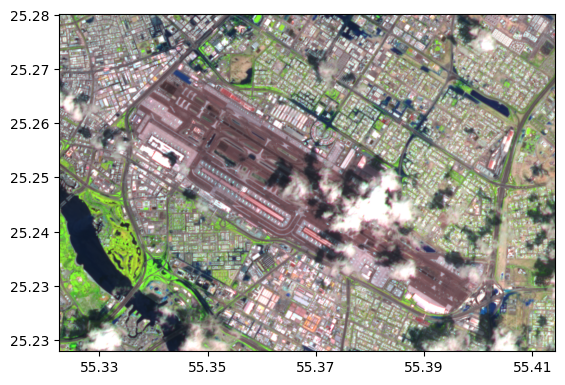

In [5]:
swirnirred = (img_local.isel({"band": [bands.index(b) for b in ["B11","B8","B4"]]}) / 4_500.).clip(0,1)

plot.show(swirnirred)

## Load the model - UNetMobV2_V1

In [6]:
model = cloudsen12.load_model_by_name(name="UNetMobV2_V1", weights_folder="cloudsen12_models")

In [7]:
cloudsen12.MODELS_CLOUDSEN12.keys()

dict_keys(['cloudsen12', 'UNetMobV2_V1', 'UNetMobV2_V2', 'cloudsen12l2a', 'dtacs4bands', 'landsat30'])

In [8]:
cloudmask = model.predict(img_local/10_000)

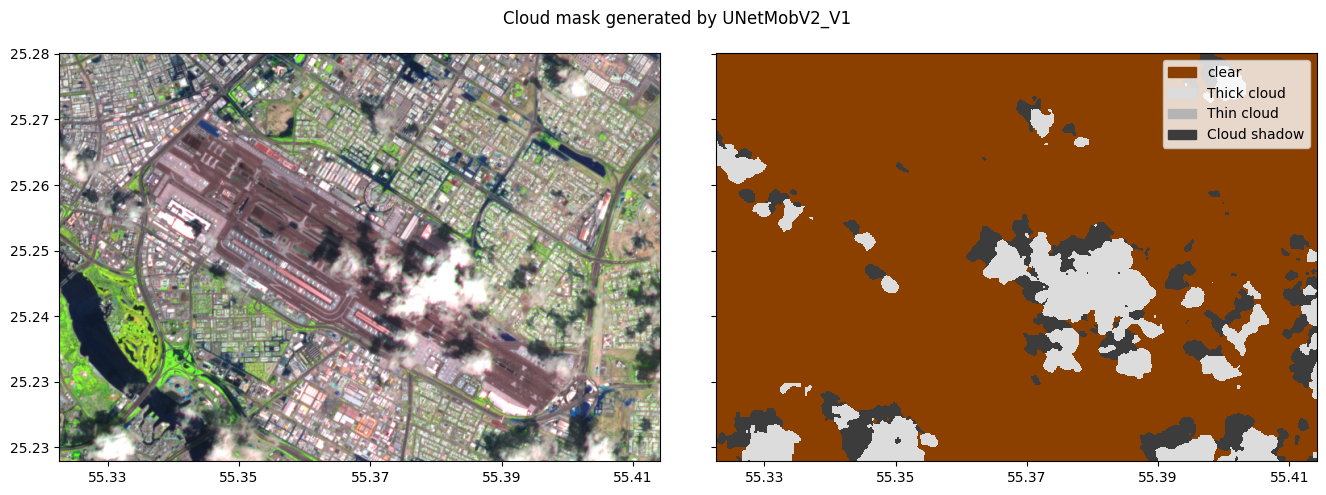

In [9]:
fig, ax = plt.subplots(1,2,figsize=(14,5),sharey=True, tight_layout=True)

plot.show(swirnirred,ax=ax[0])
cloudsen12.plot_cloudSEN12mask(cloudmask,ax=ax[1])
fig.suptitle("Cloud mask generated by UNetMobV2_V1")
fig.savefig("example_flood_dubai_2024.png")

## Explanations

In [10]:
import meteors as mt
import torch
import numpy as np

sentinel_central_wavelengths = [442.7, 492.4, 559.8, 664.6, 704.1, 740.5, 782.8, 832.8, 864.7, 945.1, 1373.5, 1613.7, 2202.4]

<Axes: >

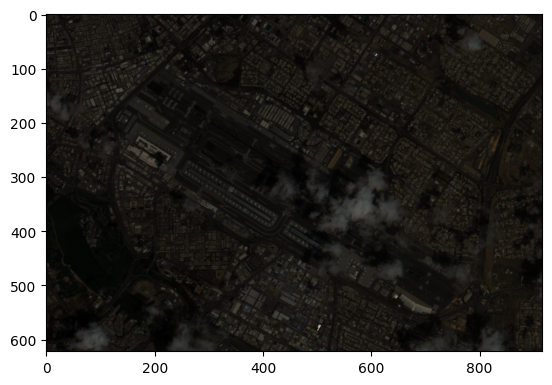

In [11]:
hsi_image = mt.HSI(image = img_local.values.astype(float)/10000, wavelengths=sentinel_central_wavelengths)

mt.visualize.visualize_hsi(hsi_image)

In [12]:
explainable_model = mt.utils.models.ExplainableModel(model.predict, problem_type="segmentation")

/tmp/ipykernel_44987/2061039508.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  segmentation_mask_raw = torch.tensor(segmentation_mask_raw)


(-0.5, 915.5, 621.5, -0.5)

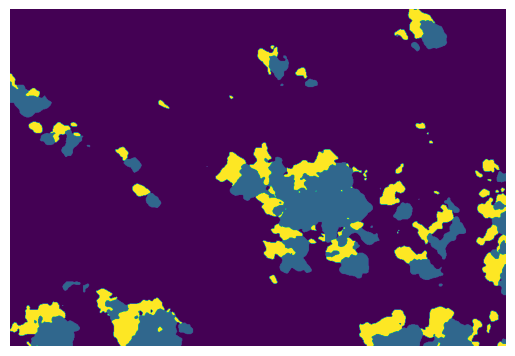

In [14]:
segmentation_mask_raw = explainable_model(hsi_image.image)
segmentation_mask_raw = torch.tensor(segmentation_mask_raw)

plt.imshow(segmentation_mask_raw[0])
plt.axis("off")

In [16]:
# cast it into 4 channels, where each channel corresponds to a class
segmentation_mask = torch.tensor(segmentation_mask_raw[0])

segmentation_mask = torch.nn.functional.one_hot(segmentation_mask.to(torch.int64), num_classes=4).permute(2,0,1).float()

/tmp/ipykernel_44987/817995685.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  segmentation_mask = torch.tensor(segmentation_mask_raw[0])


Text(0.5, 0, 'Class')

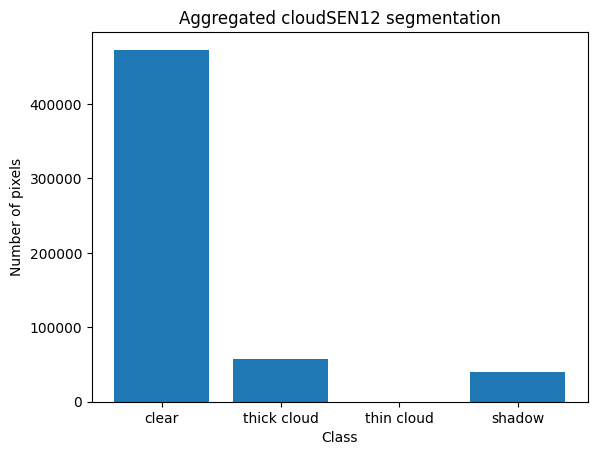

In [17]:
aggregated = segmentation_mask.sum(dim = (1,2))
plt.bar(np.arange(4), aggregated)
plt.xticks(np.arange(4), ["clear", "thick cloud", "thin cloud", "shadow"])
plt.title("Aggregated cloudSEN12 segmentation")
plt.ylabel("Number of pixels")
plt.xlabel("Class")

In [18]:
classes_numb = len(torch.unique(segmentation_mask))
classes_numb

2

In [19]:
segmentation_mask

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 

In [20]:
from meteors.utils.utils import agg_segmentation_postprocessing
postprocessing = agg_segmentation_postprocessing(classes_numb=4)

In [21]:
hsi_image.image.shape

torch.Size([13, 622, 916])

In [22]:
lime = mt.attr.Lime(explainable_model=explainable_model)

seg_mask = lime.get_segmentation_mask(hsi_image, segmentation_method="slic", num_interpret_features=100)

attributes = lime.get_spatial_attributes(hsi_image, target = 0, segmentation_mask=seg_mask, postprocessing_segmentation_output=postprocessing)

2024-09-24 23:37:52.570 | WARNING  | meteors.attr.explainer:device:153 - Not a torch model, setting device to cpu


Score of the attribution: 0.9999999995071922


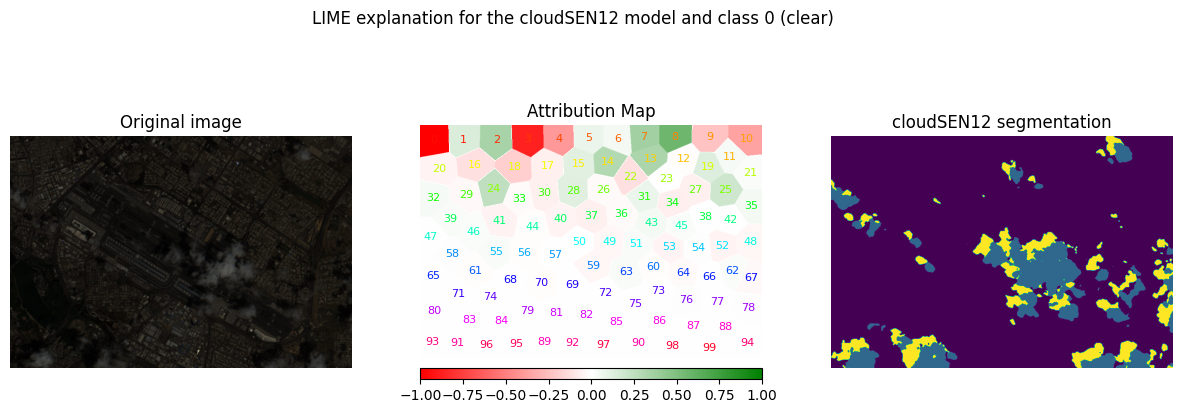

In [24]:
fig, ax = mt.visualize.visualize_spatial_attributes(attributes, use_pyplot=False)
fig.suptitle("LIME explanation for the cloudSEN12 model and class 0 (clear)")
ax[2].clear()
ax[2].imshow(segmentation_mask_raw[0])
ax[2].axis("off")
ax[2].set_title("cloudSEN12 segmentation")
print(f"Score of the attribution: {attributes.score}")

Score of the attribution: 0.9999999970419289


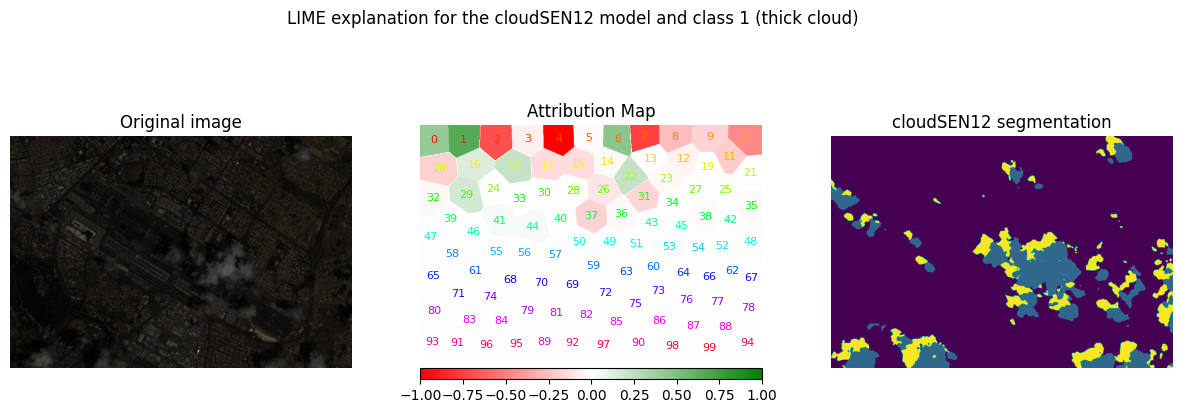

In [25]:
attributes = lime.get_spatial_attributes(hsi_image, target = 1, segmentation_mask=seg_mask, postprocessing_segmentation_output=postprocessing, num_samples=100)

fig, ax = mt.visualize.visualize_spatial_attributes(attributes, use_pyplot=False)
fig.suptitle("LIME explanation for the cloudSEN12 model and class 1 (thick cloud)")
ax[2].clear()
ax[2].imshow(segmentation_mask_raw[0])
ax[2].axis("off")
ax[2].set_title("cloudSEN12 segmentation")
print(f"Score of the attribution: {attributes.score}")

In [39]:
band_indices = {"B01": 0, "B02": 1, "B03": 2, "B04": 3, "B05": 4, "B06": 5, "B07": 6, "B08": 7, "B8A": 8, "B09": 9, "B10": 10, "B11": 11, "B12": 12}

band_mask, band_names = lime.get_band_mask(hsi_image, band_indices=band_indices)

attributes = lime.get_spectral_attributes(hsi_image, target = 0, band_mask=band_mask, band_names = band_names, postprocessing_segmentation_output=postprocessing)

/home/tymek/.conda/envs/avalanche-lib/lib/python3.10/site-packages/meteors/attr/lime_base.py:738: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn("Minimum element in feature mask is not 0, shifting indices to" " start at 0.")


2024-09-24 23:46:41.363 | WARNING  | meteors.utils.utils:adjust_shape:112 - The source tensor could not be broadcasted to match the target tensor shape. Broadcasting target tensor to match the source tensor shape.
2024-09-24 23:46:44.457 | WARNING  | meteors.utils.utils:adjust_shape:112 - The source tensor could not be broadcasted to match the target tensor shape. Broadcasting target tensor to match the source tensor shape.
2024-09-24 23:46:46.944 | WARNING  | meteors.utils.utils:adjust_shape:112 - The source tensor could not be broadcasted to match the target tensor shape. Broadcasting target tensor to match the source tensor shape.


Score of the attribution: 0.9999998976972941


Text(0.5, 0.98, 'LIME explanation for the cloudSEN12 model and class 0 (clear)')

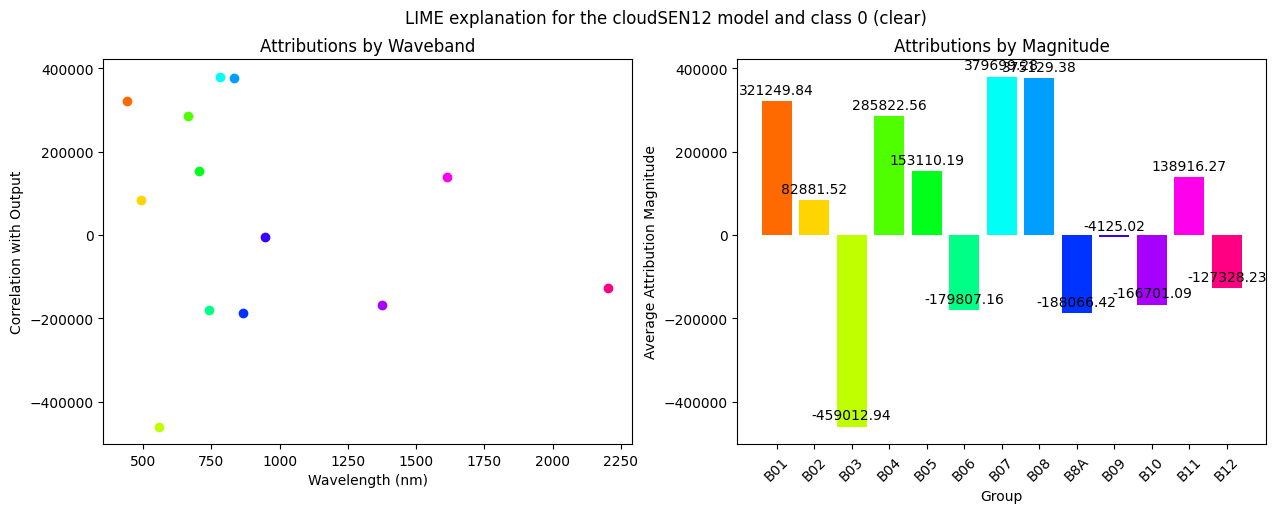

In [40]:
mt.visualize.visualize_spectral_attributes(attributes)
print(f"Score of the attribution: {attributes.score}")
fig = plt.gcf()
fig.suptitle("LIME explanation for the cloudSEN12 model and class 0 (clear)")

the bands B11, B08 and B04 are used usually to segment the clouds This hints that possibly, this method of explanations is valid

/home/tymek/.conda/envs/avalanche-lib/lib/python3.10/site-packages/meteors/attr/lime_base.py:738: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn("Minimum element in feature mask is not 0, shifting indices to" " start at 0.")


2024-09-24 23:48:10.553 | WARNING  | meteors.utils.utils:adjust_shape:112 - The source tensor could not be broadcasted to match the target tensor shape. Broadcasting target tensor to match the source tensor shape.
2024-09-24 23:48:24.848 | WARNING  | meteors.utils.utils:adjust_shape:112 - The source tensor could not be broadcasted to match the target tensor shape. Broadcasting target tensor to match the source tensor shape.
2024-09-24 23:48:39.709 | WARNING  | meteors.utils.utils:adjust_shape:112 - The source tensor could not be broadcasted to match the target tensor shape. Broadcasting target tensor to match the source tensor shape.
2024-09-24 23:48:54.225 | WARNING  | meteors.utils.utils:adjust_shape:112 - The source tensor could not be broadcasted to match the target tensor shape. Broadcasting target tensor to match the source tensor shape.
2024-09-24 23:49:07.778 | WARNING  | meteors.utils.utils:adjust_shape:112 - The source tensor could not be broadcasted to match the target tenso

Text(0.5, 0.98, 'LIME explanation for the cloudSEN12 model and class 1 (thick cloud)')

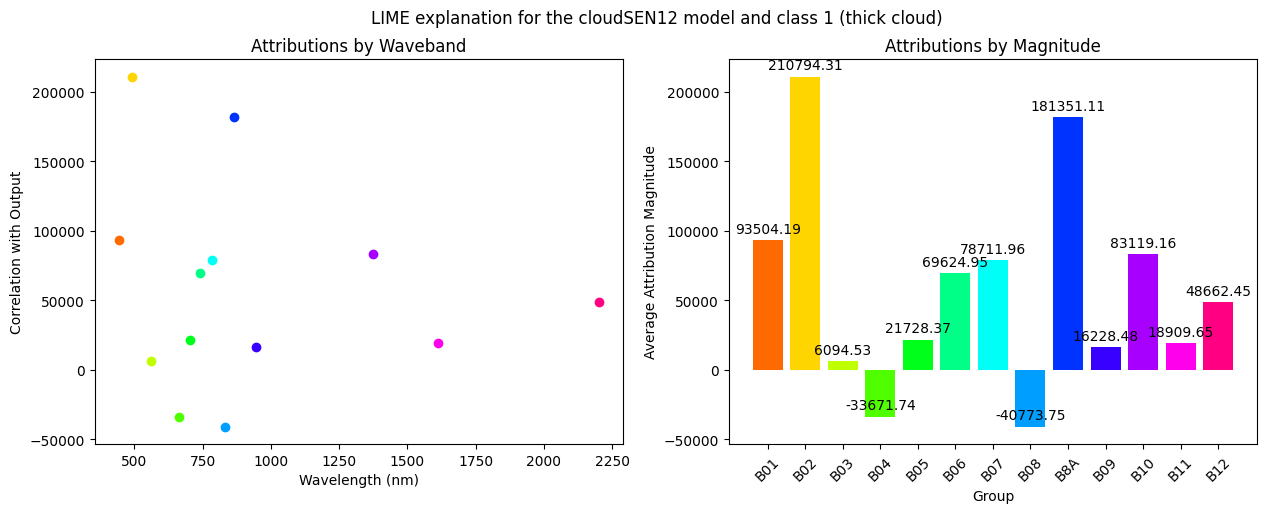

In [43]:
attributes = lime.get_spectral_attributes(hsi_image, target = 1, band_mask=band_mask, band_names = band_names, 
                                          postprocessing_segmentation_output=postprocessing, 
                                          n_samples=100, perturbations_per_eval=20)

mt.visualize.visualize_spectral_attributes(attributes)
print(f"Score of the attribution: {attributes.score}")
fig = plt.gcf()
fig.suptitle("LIME explanation for the cloudSEN12 model and class 1 (thick cloud)")
plt.show()